<a href="https://colab.research.google.com/github/visualcomments/coronavirus_data/blob/master/st_biology_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# О блокноте

На примере биологической тематики решается задача семантического поиска. Использование NLI-модели на архитектуре BERT позволяет сравнивать предложения на сходство по смыслу. Из схожих по смыслу предложений можно извлекать нужные словосочетания и отдельные слова. Попарное сходство нужных ключевых слов позволяет построить взвешенный граф и применять к интересующим нас подмножествам сущностей алгоритмы из области комбинаторики.

# Шаг 1

Для более эффективной работы с NLI-моделями помогает их дообучение на размеченном датасете из нужного домена знания.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!gdown --id 1JHGAwVGTOYLYdVHNkBvVQBychMT1Io30

Downloading...
From: https://drive.google.com/uc?id=1JHGAwVGTOYLYdVHNkBvVQBychMT1Io30
To: /content/train_dataset.zip
100% 11.6k/11.6k [00:00<00:00, 12.8MB/s]


In [ ]:
!unzip /content/train_dataset.zip

Archive:  /content/train_dataset.zip
  inflating: train_dataset .csv      


In [ ]:
df = pd.read_csv('/content/train_dataset .csv')

In [ ]:
df['mean'] = df['mean'].astype(str)

In [ ]:
df['mean'] = df['mean'].str.rstrip('%').astype('float') / 100.0

In [ ]:
lst = ['Sentence 1', 'Sentence 2']

In [ ]:
sentences = df[lst]

In [ ]:
train_label = df['mean']

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 34.7 MB/s 
     |████████████████████████████████| 6.8 MB 27.4 MB/s 
     |████████████████████████████████| 1.2 MB 35.4 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 15.9 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=417c58b5867f9de63c96ca8d568b8a5883471a3565dffe65a4b3e40c3f0cbfaf
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses

In [ ]:
model = SentenceTransformer('all-distilroberta-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def convert_text_to_examples(texts, labels):
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(texts=text,label=label)
        )
    return InputExamples

In [ ]:
train_examples = convert_text_to_examples(sentences, train_label)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [ ]:
train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

# Шаг 2

Загружаем текстовые данные и нужные нам наборы ключевых слов.

In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 85.5 MB 100 kB/s 


In [ ]:
from sentence_transformers import SentenceTransformer, util
import os
import csv
import pickle
import time
import faiss
import numpy as np

In [ ]:
!gdown --id 1bxJ4f2zzxm92nRBldQA2g-SEdjj_vs7o

Downloading...
From: https://drive.google.com/uc?id=1bxJ4f2zzxm92nRBldQA2g-SEdjj_vs7o
To: /content/genes_covid.zip
100% 283M/283M [00:03<00:00, 81.2MB/s]


In [ ]:
!unzip /content/genes_covid.zip

Archive:  /content/genes_covid.zip
  inflating: genes_covid.txt         


In [ ]:
with open('genes_covid.txt') as f:
    data = f.read().lower().splitlines()

In [ ]:
import random

In [ ]:
SEED = 123

In [ ]:
random.seed(SEED)

In [ ]:
data = random.sample(data, 100000)

In [ ]:
len(data)

100000

In [ ]:
import pandas as pd

In [ ]:
!gdown --id 1y9d1tRZAf9bXlNhf7NJxV0glHT0hB4_S

Downloading...
From: https://drive.google.com/uc?id=1y9d1tRZAf9bXlNhf7NJxV0glHT0hB4_S
To: /content/genes_human_58347_used_in_sciPlex2_brief_info_by_mygene_package.csv
100% 18.7M/18.7M [00:00<00:00, 32.1MB/s]


In [ ]:
df_genes = pd.read_csv('genes_human_58347_used_in_sciPlex2_brief_info_by_mygene_package.csv')

In [ ]:
df_genes['symbol'] = df_genes['symbol'].dropna()

In [ ]:
df_genes_sort = df_genes.sort_values(by=['count pubmed'], ascending=False)

In [ ]:
words_1 = list(df_genes_sort['symbol'].str.lower().unique())

In [ ]:
words_1 = words_1[:5000]

In [ ]:
len(words_1)

5000

In [ ]:
target_words = [
           
'SLC6A20',
'LZTFL1',
'CCR9',
'FYCO1',
'CXCR6',
'XCR1',
'ABO',
'IFNAR2',
'OAS3',
'OAS1',
'DPP9',
'ICAM5',
'TYK2',
'HLA-G',
'CCHCR1',
'HLA-DPB1',
'ACE2',
'MUC5B',
'FOXP4'

]

In [ ]:
target_words = [x.lower() for x in target_words]

In [ ]:
!gdown --id 1-ieKGEsRMNze5GYkAenASEeW2IDe0-XM

Downloading...
From: https://drive.google.com/uc?id=1-ieKGEsRMNze5GYkAenASEeW2IDe0-XM
To: /content/medicines.csv
100% 3.74k/3.74k [00:00<00:00, 6.31MB/s]


In [ ]:
df_med = pd.read_csv('medicines.csv')

In [ ]:
df_med['Generic Name'] = df_med['Generic Name'].dropna()

In [ ]:
words_2 = list(df_med['Generic Name'].str.lower().unique())

In [ ]:
!gdown --id 1igFyXIlh0RRruchgkDMrhIyT7rVBOgPW

Downloading...
From: https://drive.google.com/uc?id=1igFyXIlh0RRruchgkDMrhIyT7rVBOgPW
To: /content/dia_t.csv
100% 52.9k/52.9k [00:00<00:00, 51.3MB/s]


In [ ]:
df_dis = pd.read_csv('dia_t.csv')

In [ ]:
df_dis['diagnose'] = df_dis['diagnose'].dropna()

In [ ]:
words_3 = list(df_dis['diagnose'].str.lower().unique())

In [ ]:
len(words_3)

1166

In [ ]:
!gdown --id 1gz7d6NvMqrVn6YilWoo1E3vL5n3ZLwwK

Downloading...
From: https://drive.google.com/uc?id=1gz7d6NvMqrVn6YilWoo1E3vL5n3ZLwwK
To: /content/cells.csv
100% 8.81k/8.81k [00:00<00:00, 12.4MB/s]


In [ ]:
df_cells = pd.read_csv('cells.csv')

In [ ]:
df_cells['name'] = df_cells['name'].dropna()

In [ ]:
words_4 = list(df_cells['name'].str.lower().unique())

In [ ]:
len(words_4)

397

In [ ]:
!gdown --id 1KzyCFlIVqFzqnq7mehmSPYIVobFfDIEw

Downloading...
From: https://drive.google.com/uc?id=1KzyCFlIVqFzqnq7mehmSPYIVobFfDIEw
To: /content/symptoms.csv
100% 4.50k/4.50k [00:00<00:00, 6.49MB/s]


In [ ]:
df_symptoms = pd.read_csv('symptoms.csv')

In [ ]:
df_symptoms['symptom'] = df_symptoms['symptom'].dropna()

In [ ]:
words_5 = list(df_symptoms['symptom'].str.lower().unique())

In [ ]:
!gdown --id 122IDn2U73I6GTAzUDmMk-Yq7Sx709Yd3

Downloading...
From: https://drive.google.com/uc?id=122IDn2U73I6GTAzUDmMk-Yq7Sx709Yd3
To: /content/biomolecules.csv
100% 7.08k/7.08k [00:00<00:00, 11.3MB/s]


In [ ]:
df_biomol = pd.read_csv('biomolecules.csv')

In [ ]:
df_biomol['name'] = df_biomol['name'].dropna()

In [ ]:
words_6 = list(df_biomol['name'].str.lower().unique())

In [ ]:
!gdown --id 1NOUc3vFC8QKE_MNJ1R68NmO1omJE0Aku

Downloading...
From: https://drive.google.com/uc?id=1NOUc3vFC8QKE_MNJ1R68NmO1omJE0Aku
To: /content/viruses.csv
100% 39.7k/39.7k [00:00<00:00, 49.8MB/s]


In [ ]:
df_viruses = pd.read_csv('viruses.csv')

In [ ]:
df_viruses['name'] = df_viruses['name'].dropna()

In [ ]:
words_7 = list(df_viruses['name'].str.lower().unique())

In [ ]:
words = words_1 + words_2 + words_3 + words_4 + words_5 + words_6 + words_7

In [ ]:
len(words)

9480

# Шаг 3

Получаем эмбеддинги и основанный на них индекс, который будем использовать для определения сходства предложений.

In [ ]:
corpus_embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
faiss.normalize_L2(corpus_embeddings)

In [ ]:
d = corpus_embeddings.shape[1]

# у этой версии индекса неточный результат, но зато быстро работает на больших данных

nlist = 50
m = 8  
bits = 8 

quantizer = faiss.IndexFlatIP(d)  
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [ ]:
#index = faiss.IndexFlatL2(d)

In [ ]:
index.is_trained

False

In [ ]:
index.train(corpus_embeddings)

In [ ]:
index.add(corpus_embeddings)

In [ ]:
index.ntotal

100000

In [ ]:
def search(query):
    query_vector = model.encode([query])
    faiss.normalize_L2(query_vector)
    k = 30
    similarities, similarities_ids = index.search(query_vector.astype(np.float32), k)
    similarities = np.around(np.clip(similarities, 0, 1), decimals=4)
    highest_val_idx = np.argmax([sum(sim_vec) for sim_vec in similarities])
    l1 = [data[_id] for _id in similarities_ids.tolist()[0]]
    l2 = similarities[highest_val_idx].tolist()
    return list(zip(l1,l2))

In [ ]:
from tqdm import tqdm

In [ ]:
edgelist = []
for word in tqdm(data):
    edges = []
    for s, w in search(word):
        edges.extend((word, s, w))
    edgelist.append(edges)

100%|██████████| 100000/100000 [23:09<00:00, 71.98it/s]


# Шаг 4

Извлекаем из предложений нужные нам сущности

In [ ]:
flat_edgelist = [item for sublist in edgelist for item in sublist]

In [ ]:
edgelist_3 = [list(flat_edgelist[i:i+3]) for i in range(0, len(flat_edgelist), 3)]

In [ ]:
len(edgelist_3)

3000000

In [ ]:
import re

In [ ]:
pattern = re.compile(r'\b({})\b'.format(
    '|'.join([re.escape(word) for word in words]))
)

In [ ]:
%%time

lst2 = [num for num in edgelist_3 if re.match(pattern, num[0]) and re.match(pattern, num[1])]

CPU times: user 34min 16s, sys: 8.4 s, total: 34min 24s
Wall time: 34min 21s


In [ ]:
len(lst2)

15147

In [ ]:
lst3 = [[pattern.findall(i), pattern.findall(j), k] for i,j,k in lst2]

In [ ]:
import itertools

In [ ]:
lst4 = [list(itertools.product(a, b, [c])) for a, b, c in lst3]

In [ ]:
flat_edgelist_2 = [item for sublist in lst4 for item in sublist]

In [ ]:
len(flat_edgelist_2)

126240

In [ ]:
edgelist_3_filtered = [x for x in flat_edgelist_2 if x[0] != x[1]]

In [ ]:
len(edgelist_3_filtered)

102767

# Шаг 5

Путем суммирования весов ребер строим из найденных пар сущностей граф и применяем к данным алгоритмы определения мер центральностей и обнаружения сообществ.

In [ ]:
import networkx as nx

In [ ]:
M = nx.MultiGraph()

M.add_weighted_edges_from(edgelist_3_filtered)

In [ ]:
G = nx.Graph()
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)

In [ ]:
#to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if 0.8 >= attrs["weight"]]
#G.remove_edges_from(to_remove)

In [ ]:
#G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
remove = ['was', 't']

In [ ]:
G.remove_nodes_from(remove)

In [ ]:
print(nx.info(G))

Graph with 1661 nodes and 25139 edges


In [ ]:
G.nodes

NodeView(('trpa1', 'ca2', 'tlr9', 'ethanol', 'rho', 'gtpase', 'neurons', 'fetal alcohol syndrome', 'coenzyme', 'ace2', 'enzyme', 'ccr4', 'ceacam5', 'cxcr3', 'granzyme', 'peptidase', 'trpc6', 'muscle cells', 'orai1', 'trpc4', 'trpc3', 'epithelial cells', 'astrocytes', 'sphingosine', 'cxcl1', 'protein', 'kinase', 'growth factor', 'stress', 'hydrogen peroxide', 'androgen', 'water', 'psmb8', 'histone', 'oxidase', 'quinone', 'lox', 'loxl2', 'lysine', 'nucleic acid', 'p53', 'mtor', 'park7', 'estrogen', 'peptide', 'ang', 'ace', 'mrna', 'lung', 'infection', 'bpifa1', 'coronavirus', 'foxm1', 'cd68', 'gfap', 'vasopressin', 'constipation', 'usp18', 'interferon', 'btk', 'tnf', 'lymphocytes', 'vaccination', 'nrxn3', 'cholesterol', 'set', 'enzymes', 'star', 'vdac2', 'lipid', 'grb2', 'postn', 'asthma', 'suicide', 'casein', 'interleukin', 'cytokine', 'ins', 'actin', 'muc5ac', 'sipa1', 'tab1', 'cxcl8', 'apcs', 'cd4', 'hla-dqb1', 'mafa', 'mafb', 'glucose', 'rna', 'maf', 'insulin', 'ormdl3', 'hla-dmb', '

In [ ]:
#G = G.subgraph(nx.shortest_path(G.to_undirected(),'histamine'))

In [ ]:
[n for n in G.neighbors('cytokine')]

['stress',
 'tyrosine kinase',
 'protein',
 'kinase',
 'lipid',
 'rna',
 'nucleotide',
 'kit',
 'ethanol',
 'serine',
 'tyrosine',
 'ifih1',
 'ifit1',
 'growth factor',
 'cxcr2',
 'cxcr4',
 'cxcl10',
 'cxcl16',
 'cxcl8',
 'cxcl9',
 'ccl2',
 'cxcr3',
 'interferon',
 'dengue virus',
 'hla-g',
 'ccr9',
 'mrna',
 'lymphocytes',
 'th',
 'b cell',
 'bcl11b',
 'cd28',
 'cd4',
 'enzyme',
 'ace2',
 'cd38',
 'hiv',
 'protease',
 'lung',
 'epo',
 'peptide',
 'ang',
 'infection',
 'tyk2',
 'lilrb2',
 'interleukin',
 'kir2dl4',
 'irf5',
 'tnf',
 'ketamine',
 'foxp3',
 'cxcl12',
 'cd34',
 'stem cell',
 'ccr2',
 'cxcr1',
 'cp',
 'jak3',
 'jak1',
 'jak2',
 'hepatocytes',
 'stat1',
 'stat2',
 'hepatitis c virus',
 'hepatitis b virus',
 'ionomycin',
 'hla-e',
 'cxcr5',
 'cd19',
 'calu',
 'sucrose',
 'green fluorescent protein',
 'nucleus',
 'apc',
 'tnfsf15',
 'tnfrsf25',
 'bacterial infection',
 'mbd2',
 'ret',
 'muc5ac',
 'mafa',
 'mafb',
 'glucose',
 'maf',
 'insulin',
 'ormdl3',
 'hla-dmb',
 'histon

In [ ]:
#G = nx.read_gexf("test.gexf")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
l = ['coronavirus']

In [ ]:
deg_l = {i:G.degree(i) for i in l}    
highest_centrality_node = max(deg_l.items(), key=lambda x: x[1])[0]

In [ ]:
ego_g = nx.ego_graph(G, highest_centrality_node)

In [ ]:
from community import community_louvain
communities =community_louvain.best_partition(ego_g)

In [ ]:
community_id = [communities[node] for node in ego_g.nodes()]

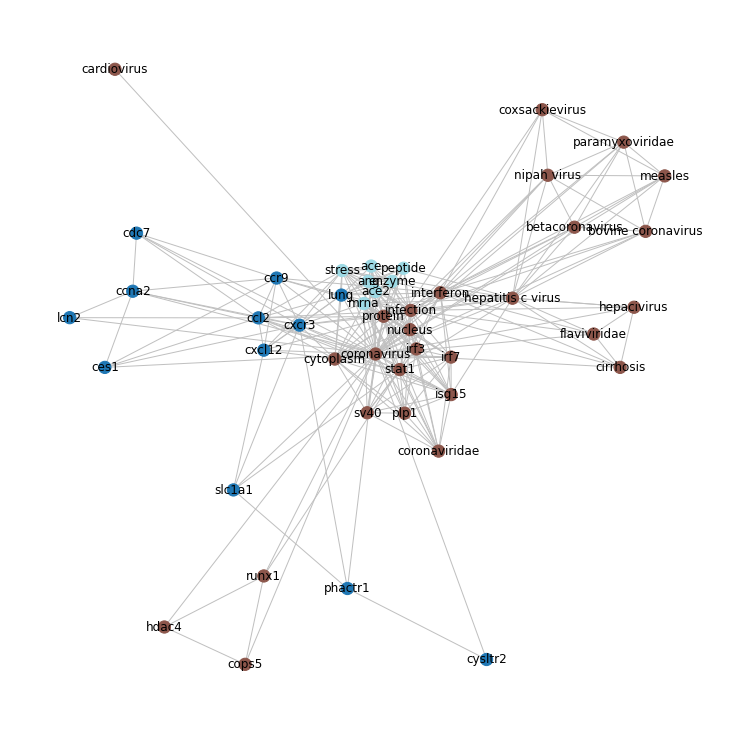

In [ ]:
fig = plt.figure(figsize=(10, 10))
d = dict(ego_g.degree)
nx.draw(
    ego_g,
    with_labels=True,
    edge_color=['silver'] * len(ego_g.edges()),
    cmap=plt.cm.tab20,
    node_color=community_id,
    nodelist=d.keys(), 
    node_size=150
)

In [ ]:
def pr_summary(G):
    pr = nx.pagerank(G)
    df = pd.DataFrame.from_dict({
        'node': list(pr.keys()),
        'centrality_pr': list(pr.values())
    })
    return df.sort_values('centrality_pr', ascending=False)

In [ ]:
pr = pd.DataFrame(pr_summary(G), columns=['node', 'centrality_pr'])

In [ ]:
pr.head()

,node,centrality_pr
25,protein,0.025671
9,ace2,0.014494
89,rna,0.010421
45,ang,0.009692
49,infection,0.008674


In [ ]:
def bc_summary(G):
    bc = nx.betweenness_centrality(G)
    df = pd.DataFrame.from_dict({
        'node': list(bc.keys()),
        'centrality_bc': list(bc.values())
    })
    return df.sort_values('centrality_bc', ascending=False)

In [ ]:
bc = pd.DataFrame(bc_summary(G), columns=['node', 'centrality_bc'])

In [ ]:
bc.head()

,node,centrality_bc
25,protein,0.177360
49,infection,0.051093
84,cd4,0.030643
26,kinase,0.025909
28,stress,0.025783


(дополнительно)
# Шаг 6

Обучем на графе графовую нейронную сеть, которую можно использовать для получения эмбеддингов вершин графа.

In [ ]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=1e1a8c55311cf8f2b0b4393dddb72cea46e643b9774850fce8e7352c3ae6af4f
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
node2vec = Node2Vec(G, dimensions=100, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/1661 [00:00<?, ?it/s]

In [ ]:
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
query = [target_words[i] for i in range(len(target_words)) if (target_words[i] in n2v_model.wv.vocab)]

In [ ]:
query

['ccr9',
 'cxcr6',
 'abo',
 'ifnar2',
 'oas3',
 'oas1',
 'dpp9',
 'tyk2',
 'hla-g',
 'hla-dpb1',
 'ace2',
 'muc5b']

In [ ]:
n2v_output = pd.DataFrame(n2v_model.wv.most_similar(positive = query, topn=30), columns=['упоминания', 'коэффициент'])

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

Text(0.5, 1.0, 'упоминания, похожие на запрос')

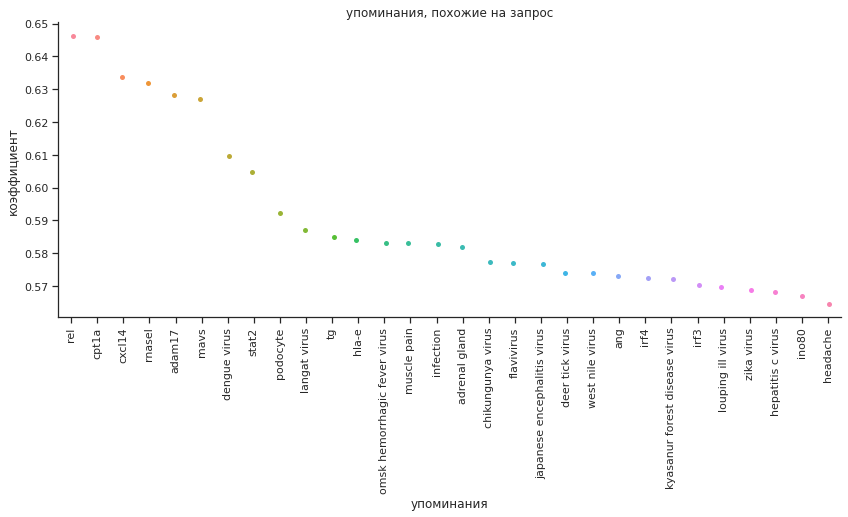

In [ ]:
g=sns.catplot(x='упоминания', y='коэффициент', data=n2v_output)
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(15,5)
plt.title('упоминания, похожие на запрос')

In [ ]:
communities =community_louvain.best_partition(G)

In [ ]:
community_id = [communities[node] for node in G.nodes()]

In [ ]:
community_list = pd.DataFrame(np.column_stack([G.nodes, community_id]), 
                               columns=['node', 'community'])

community_list.community = community_list.community.astype(int)

In [ ]:
community_list.community.value_counts()

4     360
15    226
2     204
7     175
8     110
5      97
11     84
3      78
13     77
16     70
10     70
14     66
6      36
1       3
9       2
17      1
0       1
12      1
Name: community, dtype: int64

In [ ]:
community_filter_word = community_list.loc[community_list['node'].str.contains('coronavirus')]

In [ ]:
community_filter_word

,node,community
51,coronavirus,4
1306,deltacoronavirus,4
1310,betacoronavirus,16
1311,bovine coronavirus,16


In [ ]:
community_filter = community_list.loc[community_list['community'] == 5]

In [ ]:
community_filter[:30]

,node,community
9,ace2,5
10,enzyme,5
28,stress,5
44,peptide,5
45,ang,5
46,ace,5
47,mrna,5
48,lung,5
54,gfap,5
55,vasopressin,5


(дополнительно)
# Шаг 7

Используем эмбеддинги графа для задачи мультиклассификации с помощью моделей классического машинного обучения (градиентного бустинга)

In [ ]:
df_target = community_list.copy()

In [ ]:
df_target.head()

,node,community
0,trpa1,6
1,ca2,4
2,tlr9,2
3,ethanol,3
4,rho,6


In [ ]:
x = [(n2v_model.wv[str(i)]) for i in df_target['node']]

In [ ]:
emb_df_untarget = pd.DataFrame(x, index = df_target['node'])

In [ ]:
df_target.set_index('node', inplace=True)

In [ ]:
emb_df_target = df_target.join(emb_df_untarget)

In [ ]:
df_train = emb_df_target

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data_full = df_train.copy()
X_data = data_full.drop('community', axis=1)
y = data_full.community

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_data, label_encoded_y,test_size=test_size, random_state=seed)
xgb = XGBClassifier(
    #max_depth=2,
    #gamma=2,
    #eta=0.8,
    #reg_alpha=0.5,
    #reg_lambda=0.5
)
xgb.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
predictions = xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.79%
